# PART 2: MACHINE LEARNING FORECAST

## 2.1. Data Preparation

### 2.1.1. Import and pivot the dataset

In [51]:
import pandas as pd
import numpy as np

# Define a function for data importing and pivoting
def import_data():
    """Imports data from a CSV file, creates a 'Period' column, and pivots the dataframe."""

    # Import data from CSV file
    data = pd.read_csv('norway_new_car_sales_by_make.csv')

    # Create "Period" column with format YYYY-MM (2007-01)
    data['Period'] = data['Year'].astype(str) + '-' + data['Month'].astype(str).str.zfill(2)

    # Pivot the dataframe
    df = pd.pivot_table(
        data=data,
        values='Quantity',
        index='Make',
        columns='Period',
        aggfunc='sum',
        fill_value=0
    )
    return df


# Run the function and display the first few rows of the result
df = import_data()
df.head()

Period,2007-01,2007-02,2007-03,2007-04,2007-05,2007-06,2007-07,2007-08,2007-09,2007-10,...,2016-04,2016-05,2016-06,2016-07,2016-08,2016-09,2016-10,2016-11,2016-12,2017-01
Make,,,,,,,,,,,,,,,,,,,,,
Alfa Romeo,16,9,21,20,17,21,14,12,15,10,...,3,1,2,1,6,15,3,4,3,6
Aston Martin,0,0,1,0,4,3,3,0,0,0,...,0,0,1,0,0,0,0,0,0,0
Audi,599,498,682,556,630,498,562,590,393,554,...,685,540,551,687,794,688,603,645,827,565
BMW,352,335,365,360,431,477,403,348,271,562,...,1052,832,808,636,1031,1193,1096,1663,866,1540
Bentley,0,0,0,0,0,1,0,0,0,0,...,0,0,1,1,1,0,0,0,0,0


### 2.1.2. Split the dataset into train set and test set

In [52]:
# Define a function to split the dataset into train set and test set
def datasets(df, x_len=12, y_len=1, test_loops=12):
    """Splits the dataframe into training and testing sets based on the specified lengths and test loops."""

    # Get the values and shape of the dataframe
    data_values = df.values
    rows, periods = data_values.shape

    # Total number of loops (including both train and test loops)
    loops = periods + 1 - x_len - y_len

    # Create initial train set
    train = []
    for col in range(loops):
        train.append(data_values[:, col:col + x_len + y_len])
    train = np.vstack(train)
    X_train, Y_train = np.split(train, [-y_len], axis=1)

    # Split the initial train set into train set and test set when test_loops is specified
    if test_loops > 0:
        X_train, X_test = np.split(X_train, [-rows * test_loops], axis=0)
        Y_train, Y_test = np.split(Y_train, [-rows * test_loops], axis=0)
    else:
        X_test = data_values[:, -x_len:]
        Y_test = np.full((X_test.shape[0], y_len), np.nan)

    # Reformat y_train and y_test to meet scikit-learn requirements
    if y_len == 1:
        Y_train = Y_train.ravel()
        Y_test = Y_test.ravel()

    # Return the train set and test set arrays
    return X_train, Y_train, X_test, Y_test


# Run the function to split the dataset into train set and test set
X_train, Y_train, X_test, Y_test = datasets(df)

## 2.2. ML Forecasting KPIs

In [53]:
# Define a function to calculate forecasting accuracy KPIs
def kpi_ML(Y_train, Y_train_pred, Y_test, Y_test_pred, name=''):
    """Calculate and display MAE, RMSE, and Bias for train and test sets."""

    # Initialize dataframe to store the results
    df = pd.DataFrame(columns=['MAE', 'RMSE', 'Bias'], index=['Train', 'Test'])
    df.index.name = name

    # Calculate metrics for the train set
    df.loc['Train', 'MAE'] = 100 * np.mean(abs(Y_train - Y_train_pred)) / np.mean(Y_train)
    df.loc['Train', 'RMSE'] = 100 * np.sqrt(np.mean((Y_train - Y_train_pred)**2)) / np.mean(Y_train)
    df.loc['Train', 'Bias'] = 100 * np.mean((Y_train - Y_train_pred)) / np.mean(Y_train)

    # Calculate metrics for the test set
    df.loc['Test', 'MAE'] = 100 * np.mean(abs(Y_test - Y_test_pred)) / np.mean(Y_test)
    df.loc['Test', 'RMSE'] = 100 * np.sqrt(np.mean((Y_test - Y_test_pred)**2)) / np.mean(Y_test)
    df.loc['Test', 'Bias'] = 100 * np.mean((Y_test - Y_test_pred)) / np.mean(Y_test)

    # Format the dataframe for better presentation
    df = df.astype(float).round(1)

    # Print the results
    print(df)

## 2.3. Linear Regression

### 2.3.1. Run the model

In [54]:
from sklearn.linear_model import LinearRegression

# Setup model and fit train set
reg = LinearRegression()
reg.fit(X_train, Y_train)

# Forecast and return forecasting accuracy KPIs
Y_train_pred = reg.predict(X_train)
Y_test_pred = reg.predict(X_test)

kpi_ML(Y_train, Y_train_pred, Y_test, Y_test_pred, name='Regression')

             MAE  RMSE  Bias
Regression                  
Train       17.8  43.9   0.0
Test        17.8  43.7   1.6


### 2.3.2. Use the model to forecast

In [55]:
# Forecast for the future (with test_loops = 0)
X_train_reg, Y_train_reg, X_test_reg, Y_test_reg = datasets(df, x_len=12, y_len=1, test_loops=0)

reg = LinearRegression()
reg.fit(X_train_reg, Y_train_reg)

forecast = pd.DataFrame(
    data=reg.predict(X_test_reg),
    index=df.index,
    columns=['Forecasting result']
)

print(forecast.head())

              Forecasting result
Make                            
Alfa Romeo              6.187217
Aston Martin            1.032483
Audi                  646.568622
BMW                  1265.032834
Bentley                 1.218092


## 2.4. Decision Tree

### 2.4.1. Run the model

In [56]:
from sklearn.tree import DecisionTreeRegressor

# Setup model and fit train set
tree = DecisionTreeRegressor(max_depth=5, min_samples_split=15, min_samples_leaf=5)
tree.fit(X_train, Y_train)

# Forecast and return forecasting accuracy KPIs
Y_train_pred = tree.predict(X_train)
Y_test_pred = tree.predict(X_test)

kpi_ML(Y_train, Y_train_pred, Y_test, Y_test_pred, name='Tree')

        MAE  RMSE  Bias
Tree                   
Train  18.1  43.4  -0.0
Test   21.1  52.6   3.2


### 2.4.2. Visualize the tree

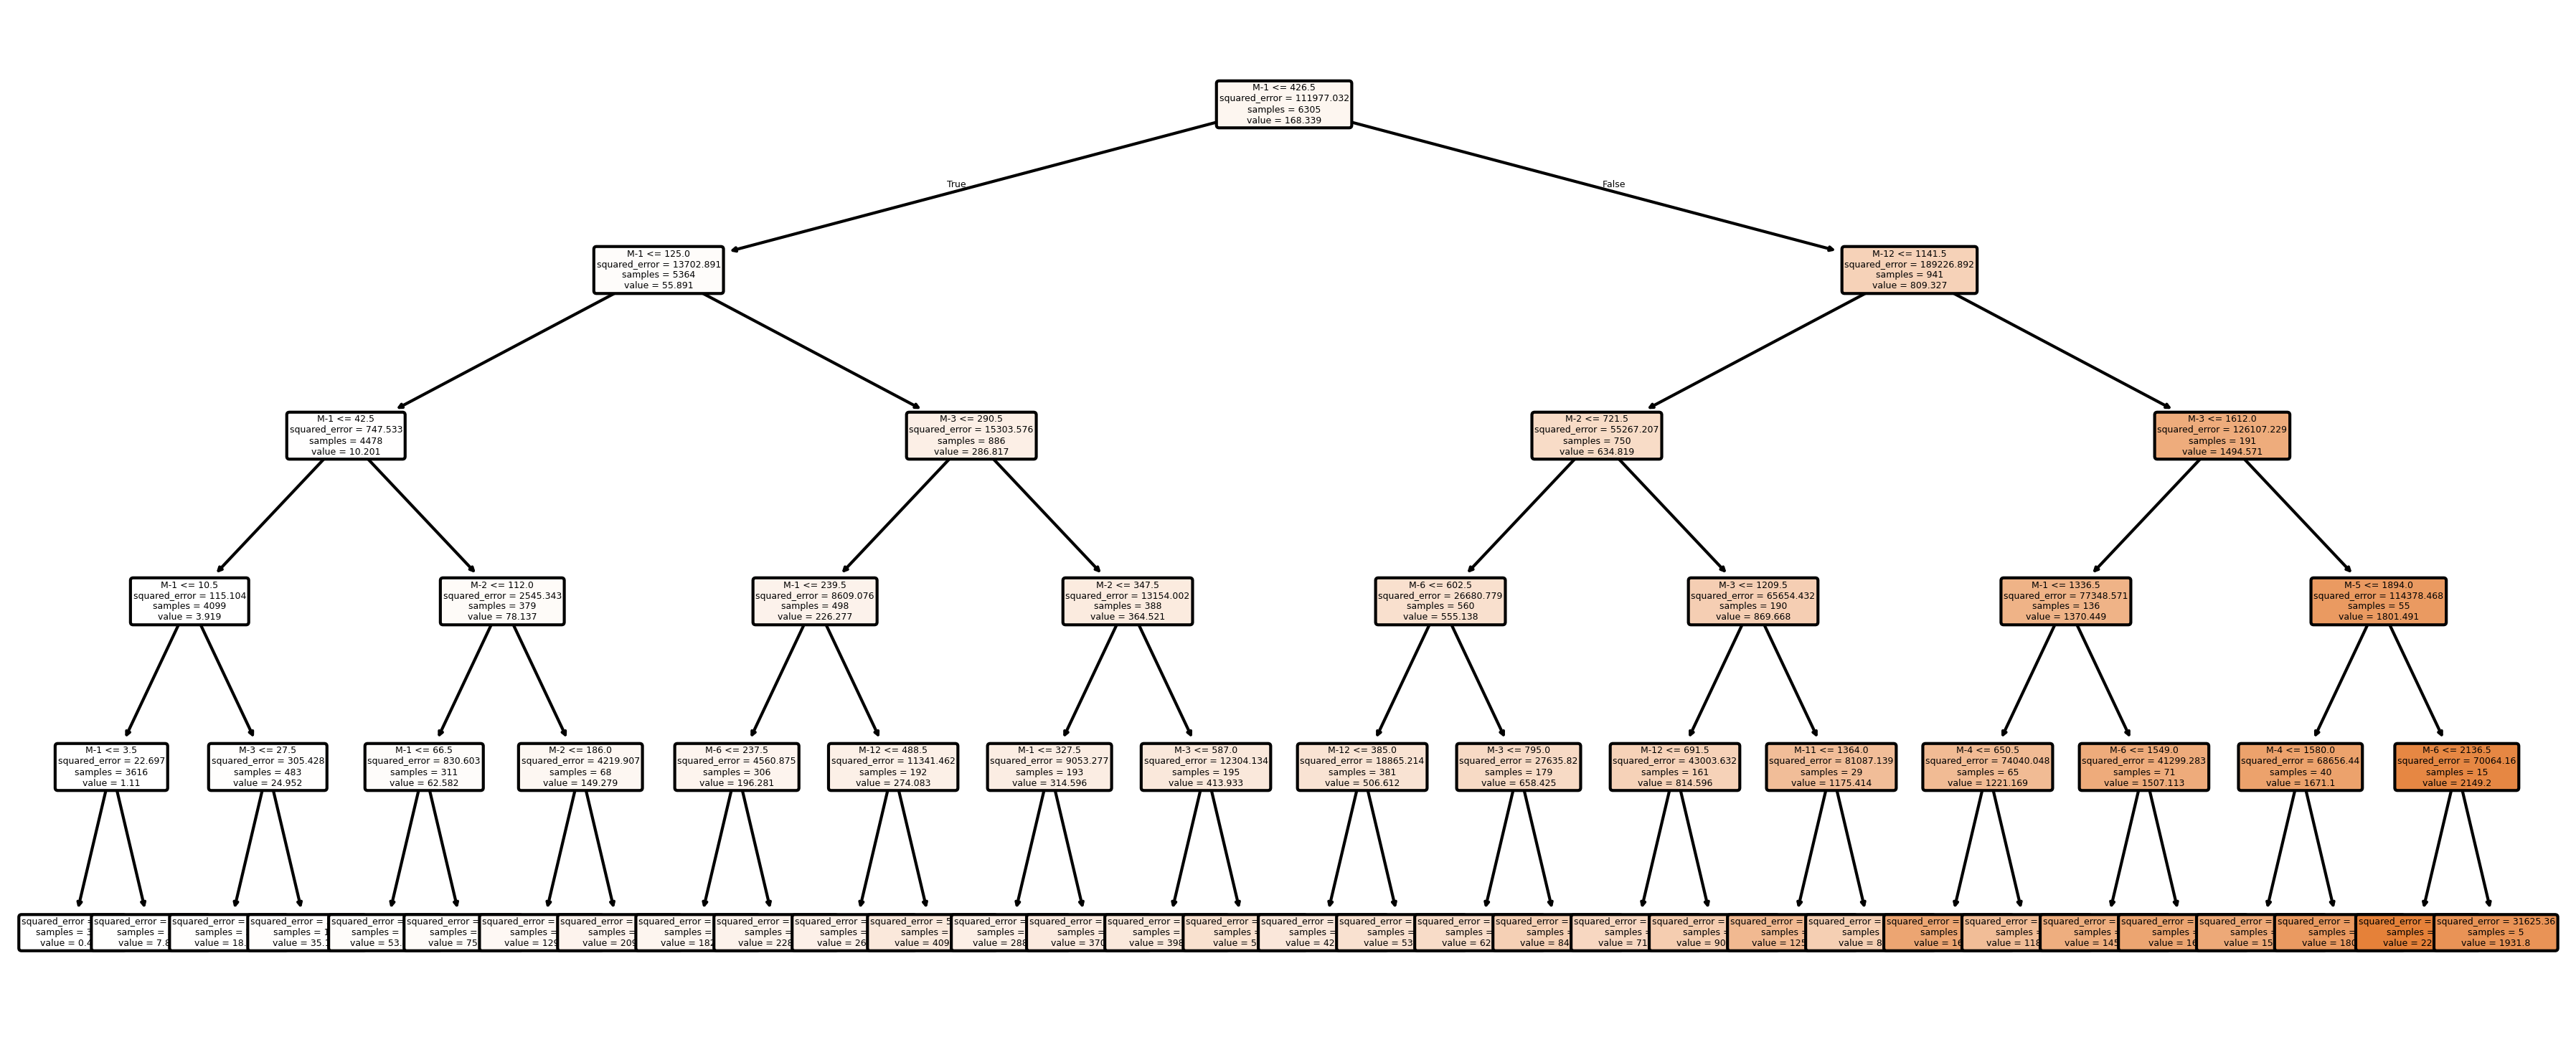

In [57]:
from sklearn.tree import plot_tree
import matplotlib.pyplot as plt

# Create figure and axis for the tree visualization
fig = plt.figure(figsize=(15, 6), dpi=300)
ax = fig.add_subplot(111)

# Visualize the tree and save as an image
plot_tree(tree, fontsize=3, feature_names=[f'M{x-12}' for x in range(12)],
          rounded=True, filled=True, ax=ax)
fig.savefig('Regression_Tree.PNG')

### 2.4.3. Forecast accuracy and time comparison between criterion MSE and MAE

In [58]:
import time

# Dictionary to store results
results = []

# Loop through different criteria
for criterion in ['squared_error', 'absolute_error']:
    start_time = time.time()

    # Initialize and fit the model
    tree = DecisionTreeRegressor(
        max_depth=5, min_samples_split=15, min_samples_leaf=5, criterion=criterion
    )
    tree.fit(X_train, Y_train)

    # Predict and evaluate KPIs
    Y_train_pred = tree.predict(X_train)
    Y_test_pred = tree.predict(X_test)
    kpi_ML(Y_train, Y_train_pred, Y_test, Y_test_pred, name=f'Tree {criterion}')
    print()

    # Record training time
    training_time = time.time() - start_time
    results.append([criterion, training_time])

# Convert results to DataFrame for easier comparison
results_df = pd.DataFrame(results, columns=['Criterion', 'Training Time (seconds)'])
print(results_df)

                     MAE  RMSE  Bias
Tree squared_error                  
Train               18.1  43.4  -0.0
Test                21.1  52.6   3.2

                      MAE  RMSE  Bias
Tree absolute_error                  
Train                17.9  47.0   2.3
Test                 21.5  58.5   5.2

        Criterion  Training Time (seconds)
0   squared_error                 0.025352
1  absolute_error                 0.956529


## 2.5. Parameter Optimization (Decision Tree examples)

In [59]:
from sklearn.model_selection import RandomizedSearchCV

# Parameter grid
max_depth = list(range(5, 11)) + [None]
min_samples_split = range(5, 20)
min_samples_leaf = range(2, 20)
param_dist = {
    'max_depth': max_depth,
    'min_samples_split': min_samples_split,
    'min_samples_leaf': min_samples_leaf
}

# Setup model
tree = DecisionTreeRegressor()

# Apply K-Fold Cross-Validation & Random Search with MAE scoring
tree_cv = RandomizedSearchCV(
    estimator=tree, param_distributions=param_dist, n_iter=100,
    scoring='neg_mean_absolute_error', n_jobs=-1, cv=10, verbose=1
)
tree_cv.fit(X_train, Y_train)

# Output the best parameters and score
print('Tuned Regression Tree Parameters:', tree_cv.best_params_)
print('Best Cross-Validation MAE:', -tree_cv.best_score_)  # Negate to get positive MAE

Fitting 10 folds for each of 100 candidates, totalling 1000 fits
Tuned Regression Tree Parameters: {'min_samples_split': 14, 'min_samples_leaf': 17, 'max_depth': 6}
Best Cross-Validation MAE: 34.10953024034445


In [60]:
# Use the tuned model with optimized parameters to forecast and return forecasting accuracy KPIs
y_train_pred = tree_cv.predict(X_train)
y_test_pred = tree_cv.predict(X_test)

kpi_ML(Y_train, Y_train_pred, Y_test, Y_test_pred, name='Tree')
print()

# Check the detail K-Fold Cross-Validation & Random Search result
cv_result = pd.DataFrame(tree_cv.cv_results_)
print(cv_result.head())

        MAE  RMSE  Bias
Tree                   
Train  17.9  47.0   2.3
Test   21.5  58.5   5.2

   mean_fit_time  std_fit_time  mean_score_time  std_score_time  \
0       0.021801      0.001437         0.001338        0.000234   
1       0.028182      0.001511         0.001344        0.000177   
2       0.035854      0.005925         0.001358        0.000118   
3       0.028997      0.001305         0.001473        0.000102   
4       0.030022      0.001187         0.001445        0.000085   

   param_min_samples_split  param_min_samples_leaf param_max_depth  \
0                       18                      16               6   
1                        5                      19            None   
2                        5                       8            None   
3                       13                      17            None   
4                        7                      14            None   

                                              params  split0_test_score  \
0  {

## 2.6. Random Forest

### 2.6.1. Run the model

In [61]:
from sklearn.ensemble import RandomForestRegressor

# Setup model and fit train set
forest = RandomForestRegressor(
    bootstrap=True,
    max_samples=0.95,
    max_features=11,
    min_samples_leaf=18,
    max_depth=7
)
forest.fit(X_train, Y_train)

# Forecast and return forecasting accuracy KPIs
Y_train_pred = forest.predict(X_train)
Y_test_pred = forest.predict(X_test)
kpi_ML(Y_train, Y_train_pred, Y_test, Y_test_pred, name='Forest')

         MAE  RMSE  Bias
Forest                  
Train   15.7  40.0  -0.0
Test    18.4  46.9   3.7


### 2.6.2. Parameter optimization with n_estimators=30

In [62]:
# Parameter grid
max_depth = list(range(5, 11)) + [None]
min_samples_split = range(5, 20)
min_samples_leaf = range(2, 15)
max_features = range(3, 8)
bootstrap = [True]
max_samples = [.7, .8, .9, .95, 1]

param_dist = {
    'max_depth': max_depth,
    'min_samples_split': min_samples_split,
    'min_samples_leaf': min_samples_leaf,
    'max_features': max_features,
    'bootstrap': bootstrap,
    'max_samples': max_samples
}

# Apply K-Fold Cross-Validation & Random Search with MAE scoring to the model
forest = RandomForestRegressor(n_jobs=1, n_estimators=30)
forest_cv = RandomizedSearchCV(
    estimator=forest,
    param_distributions=param_dist,
    cv=6,
    n_jobs=-1,
    verbose=2,
    n_iter=400,
    scoring='neg_mean_absolute_error'
)

forest_cv.fit(X_train, Y_train)
print('Tuned Forest Parameters:', forest_cv.best_params_)

# Use the tuned model with optimized parameters to forecast and return forecasting accuracy KPIs
Y_train_pred = forest_cv.predict(X_train)
Y_test_pred = forest_cv.predict(X_test)
kpi_ML(Y_train, Y_train_pred, Y_test, Y_test_pred, name='Forest optimized')

Fitting 6 folds for each of 400 candidates, totalling 2400 fits
Tuned Forest Parameters: {'min_samples_split': 7, 'min_samples_leaf': 7, 'max_samples': 0.8, 'max_features': 6, 'max_depth': None, 'bootstrap': True}
                   MAE  RMSE  Bias
Forest optimized                  
Train             13.6  34.9  -0.1
Test              17.7  46.0   2.6


### 2.6.3. Parameter optimization with n_estimators=200

In [63]:
# Use the tuned model with optimized parameters and n_estimators = 200 to forecast and return forecasting accuracy KPIs
forest = RandomForestRegressor(n_estimators=200, n_jobs=-1, **forest_cv.best_params_)
forest = forest.fit(X_train, Y_train)
Y_train_pred = forest.predict(X_train)
Y_test_pred = forest.predict(X_test)
kpi_ML(Y_train, Y_train_pred, Y_test, Y_test_pred, name='Forest n_estimators = 200')

                            MAE  RMSE  Bias
Forest n_estimators = 200                  
Train                      13.5  34.9   0.0
Test                       17.6  45.4   2.8


## 2.7. Feature Importance (Random Forest examples)

<Axes: >

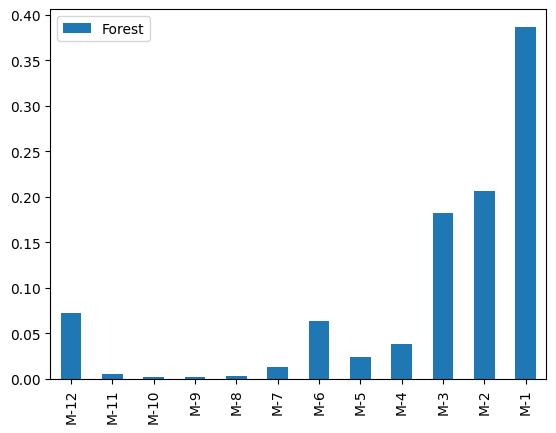

In [64]:
# Number of train features
cols = X_train.shape[1]

# Get the feature list
features = [f'M-{cols - col}' for col in range(cols)]

# Create the feature importance dataframe
feature_importance = pd.DataFrame(data=forest.feature_importances_.reshape(-1, 1),
                                  index=features,
                                  columns=['Forest'])

# Visualize the feature importance chart
feature_importance.plot(kind='bar')

## 2.8. Extremely Randomized Trees/Extra Trees

### 2.8.1. Run the model

In [65]:
from sklearn.ensemble import ExtraTreesRegressor

# Setup the model
ETR = ExtraTreesRegressor(n_jobs=-1, n_estimators=200, min_samples_split=15,
                          min_samples_leaf=4, max_samples=0.95, max_features=4,
                          max_depth=8, bootstrap=True)

# Fit train set to the model
ETR.fit(X_train, Y_train)

# Use the model to predict train and test sets
Y_train_pred = ETR.predict(X_train)
Y_test_pred = ETR.predict(X_test)

# Return forecasting accuracy KPIs
kpi_ML(Y_train, Y_train_pred, Y_test, Y_test_pred, name='ETR')

        MAE  RMSE  Bias
ETR                    
Train  17.8  43.6   0.0
Test   18.9  47.1   3.3


### 2.8.2. Parameter optimization with n_estimators=30

In [66]:
# Parameter grid
max_depth = list(range(6, 13)) + [None]
min_samples_split = range(7, 16)
min_samples_leaf = range(2, 13)
max_features = range(5, 13)
bootstrap = [True]
max_samples = [.7, .8, .9, .95, 1]

param_dist = {'max_depth': max_depth,
              'min_samples_split': min_samples_split,
              'min_samples_leaf': min_samples_leaf,
              'max_features': max_features,
              'bootstrap': bootstrap,
              'max_samples': max_samples}

ETR = ExtraTreesRegressor(n_jobs=1, n_estimators=30)
ETR_cv = RandomizedSearchCV(ETR, param_dist, cv=5, verbose=2, n_jobs=-1,
                            n_iter=400, scoring='neg_mean_absolute_error')
ETR_cv.fit(X_train, Y_train)

print('Tuned Forest Parameters:', ETR_cv.best_params_)

# Use the tuned model to predict train and test sets
Y_train_pred = ETR_cv.predict(X_train)
Y_test_pred = ETR_cv.predict(X_test)
kpi_ML(Y_train, Y_train_pred, Y_test, Y_test_pred, name='ETR optimized')

Fitting 5 folds for each of 400 candidates, totalling 2000 fits
Tuned Forest Parameters: {'min_samples_split': 7, 'min_samples_leaf': 3, 'max_samples': 0.95, 'max_features': 12, 'max_depth': 8, 'bootstrap': True}
                MAE  RMSE  Bias
ETR optimized                  
Train          15.0  36.4  -0.1
Test           17.5  44.2   2.4


### 2.8.3. Parameter optimization with n_estimators=200

In [67]:
# Run the tuned model with 200 trees
ETR = ExtraTreesRegressor(n_estimators=200, n_jobs=-1, **ETR_cv.best_params_).fit(X_train, Y_train)
Y_train_pred = ETR.predict(X_train)
Y_test_pred = ETR.predict(X_test)
kpi_ML(Y_train, Y_train_pred, Y_test, Y_test_pred, name='ETR x200')

           MAE  RMSE  Bias
ETR x200                  
Train     14.9  36.6   0.1
Test      17.4  44.4   2.5


## 2.9. Feature Optimization #1 (Random Forest and Extremely Randomized Trees examples)

### 2.9.1. Determine the optimal number of feature using train set

In [68]:
# Get the dataframe
df = import_data()

# Define RandomForestRegressor parameters
forest_features = {
    "n_jobs": -1,
    "n_estimators": 200,
    "min_samples_split": 15,
    "min_samples_leaf": 4,
    "max_samples": 0.95,
    "max_features": 0.3,
    "max_depth": 8,
    "bootstrap": True
}
forest = RandomForestRegressor(**forest_features)

# Define ExtraTreesRegressor parameters
etr_features = {
    "n_jobs": -1,
    "n_estimators": 200,
    "min_samples_split": 14,
    "min_samples_leaf": 2,
    "max_samples": 0.9,
    "max_features": 1.0,
    "max_depth": 12,
    "bootstrap": True
}
etr = ExtraTreesRegressor(**etr_features)

# List of models
models = [("Forest", forest), ("ETR", etr)]

In [69]:
# Create function to return MAE
def model_mae(model, X, y):
    y_pred = model.predict(X)
    mae = np.mean(np.abs(y - y_pred)) / np.mean(y)
    return mae

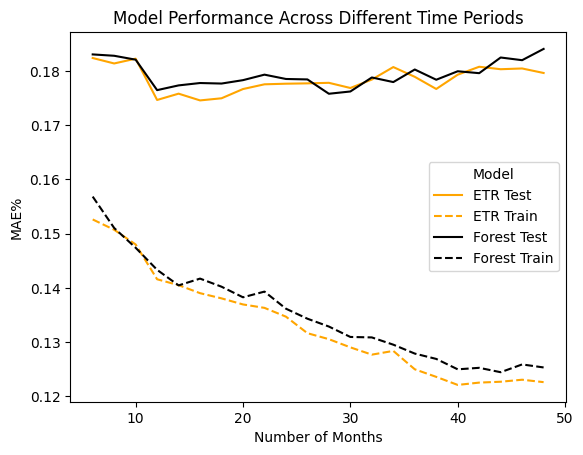

Model
ETR Test        16
ETR Train       40
Forest Test     28
Forest Train    44
dtype: int64


In [71]:
# Define range for months (from 6 to 50 with a 2-month gap)
n_months = range(6, 50, 2)

# Empty list to store the results
results = []

# Train and test models to find the optimal number of features
for x_len in n_months:
    X_train, Y_train, X_test, Y_test = datasets(df, x_len=x_len)

    for name, model in models:
        model.fit(X_train, Y_train)
        mae_train = model_mae(model, X_train, Y_train)
        mae_test = model_mae(model, X_test, Y_test)

        results.append([f"{name} Train", mae_train, x_len])
        results.append([f"{name} Test", mae_test, x_len])

# Format results into a DataFrame for visualization
data = pd.DataFrame(results, columns=["Model", "MAE%", "Number of Months"])
data = data.set_index(["Number of Months", "Model"]).stack().unstack("Model")
data.index = data.index.droplevel(level=1)
data.index.name = "Number of Months"

# Visualize the results
data.plot(color=["orange"] * 2 + ["black"] * 2, style=["-", "--"] * 2)
plt.xlabel("Number of Months")
plt.ylabel("MAE%")
plt.title("Model Performance Across Different Time Periods")
plt.show()

# Print the optimal number of features
print(data.idxmin())

### 2.9.2. Determine the optimal number of feature using validation set with folds

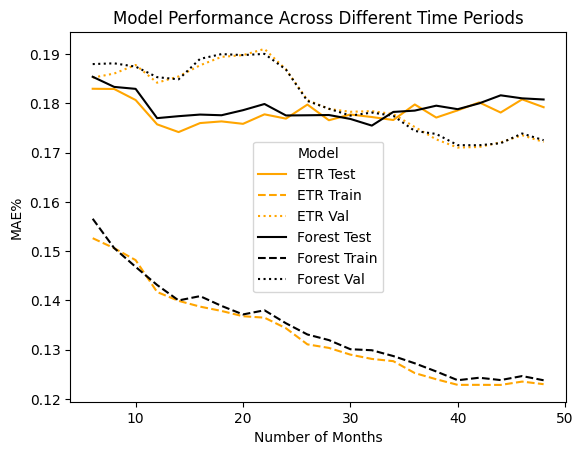

Model
ETR Test        14
ETR Train       44
ETR Val         40
Forest Test     32
Forest Train    48
Forest Val      42
dtype: int64


In [72]:
from sklearn.model_selection import KFold

# Empty list for storing results
results = []

# Loop through each feature option
for x_len in n_months:
    X_train, y_train, X_test, y_test = datasets(df, x_len=x_len)

    for name, model in models:
        mae_kfold_train = []
        mae_kfold_val = []

        # Split the train set into k folds
        kf = KFold(n_splits=8)
        for train_index, val_index in kf.split(X_train):
            X_train_kfold, X_val_kfold = X_train[train_index], X_train[val_index]
            y_train_kfold, y_val_kfold = y_train[train_index], y_train[val_index]

            # Fit each fold into the model
            model.fit(X_train_kfold, y_train_kfold)

            # Calculate MAE for train and validation sets
            mae_train = model_mae(model, X_train_kfold, y_train_kfold)
            mae_val = model_mae(model, X_val_kfold, y_val_kfold)

            mae_kfold_train.append(mae_train)
            mae_kfold_val.append(mae_val)

        # Append results
        results.append([f"{name} Val", np.mean(mae_kfold_val), x_len])
        results.append([f"{name} Train", np.mean(mae_kfold_train), x_len])

        # Fit the model on the entire train set and evaluate on the test set
        model.fit(X_train, y_train)
        mae_test = model_mae(model, X_test, y_test)
        results.append([f"{name} Test", mae_test, x_len])

# Format results into a DataFrame for visualization
data = pd.DataFrame(results, columns=["Model", "MAE%", "Number of Months"])
data = data.set_index(["Number of Months", "Model"]).stack().unstack("Model")
data.index = data.index.droplevel(level=1)
data.index.name = "Number of Months"

# Plot the results
data.plot(color=["orange"] * 3 + ["black"] * 3, style=["-", "--", ":"] * 2)
plt.xlabel("Number of Months")
plt.ylabel("MAE%")
plt.title("Model Performance Across Different Time Periods")
plt.show()

# Print the optimal number of features
print(data.idxmin())

### 2.9.3. Determine the optimal number of feature using holdout set

In [78]:
# Function to create holdout set
def datasets_holdout(df, x_len=12, y_len=1, test_loops=12, holdout_loops=0):
    data_values = df.values
    rows, periods = data_values.shape

    # Training set creation
    train_loops = periods + 1 - x_len - y_len - test_loops
    train = [data_values[:, col : col + x_len + y_len] for col in range(train_loops)]
    train = np.vstack(train)
    X_train, Y_train = np.split(train, [-y_len], axis=1)

    # Holdout set creation
    if holdout_loops > 0:
        X_train, X_holdout = np.split(X_train, [-rows * holdout_loops], axis=0)
        Y_train, Y_holdout = np.split(Y_train, [-rows * holdout_loops], axis=0)
    else:
        X_holdout, Y_holdout = np.array([]), np.array([])

    # Test set creation
    if test_loops > 0:
        X_train, X_test = np.split(X_train, [-rows * test_loops], axis=0)
        Y_train, Y_test = np.split(Y_train, [-rows * test_loops], axis=0)
    else:  # No test set: X_test is used to generate the future forecast
        X_test = data_values[:, -x_len:]
        y_test = np.full((X_test.shape[0], y_len), np.nan)  # Dummy value

    # Formatting required for scikit-learn
    if y_len == 1:
        Y_train = Y_train.ravel()
        Y_test = Y_test.ravel()
        Y_holdout = Y_holdout.ravel()

    return X_train, Y_train, X_holdout, Y_holdout, X_test, Y_test

Model
ETR Holdout       28
ETR Test          12
ETR Train         42
Forest Holdout    24
Forest Test       12
Forest Train      40
dtype: int64


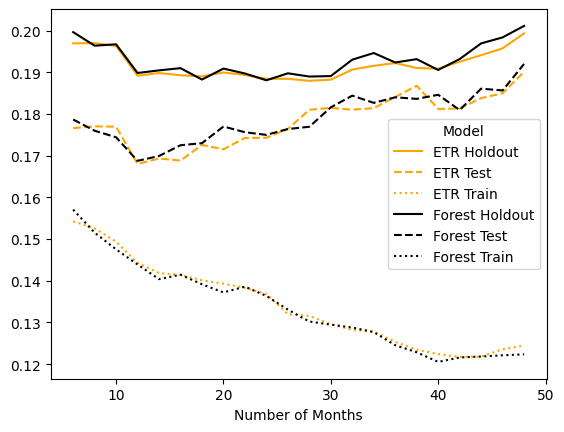

In [79]:
# Create the holdout set and fit into the model to find the optimal number of features
results = []

for x_len in n_months:
    X_train, Y_train, X_holdout, Y_holdout, X_test, Y_test = datasets_holdout(
        df, x_len=x_len, holdout_loops=12
    )

    for name, model in models:
        model.fit(X_train, Y_train)
        mae_train = model_mae(model, X_train, Y_train)
        mae_holdout = model_mae(model, X_holdout, Y_holdout)
        mae_test = model_mae(model, X_test, Y_test)

        results.append([f"{name} Train", mae_train, x_len])
        results.append([f"{name} Test", mae_test, x_len])
        results.append([f"{name} Holdout", mae_holdout, x_len])

# Create dataframe to print the result
data = pd.DataFrame(results, columns=["Model", "MAE%", "Number of Months"])
data = data.set_index(["Number of Months", "Model"]).stack().unstack("Model")
data.index = data.index.droplevel(level=1)
data.index.name = "Number of Months"

# Plotting the result
data.plot(
    color=["orange"] * 3 + ["black"] * 3,
    style=["-", "--", ":"] * 3
)

# Print the optimal number of months
print(data.idxmin())

## 2.10. Adaptive Boosting/AdaBoost

### 2.10.1. Run the model

In [80]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import AdaBoostRegressor

ada = AdaBoostRegressor(DecisionTreeRegressor(max_depth=8), n_estimators=100, learning_rate=0.25, loss='square')
ada = ada.fit(X_train, Y_train)

Y_train_pred = ada.predict(X_train)
Y_test_pred = ada.predict(X_test)
kpi_ML(Y_train, Y_train_pred, Y_test, Y_test_pred, name='AdaBoost')

           MAE  RMSE  Bias
AdaBoost                  
Train      5.0  10.9  -0.1
Test      19.8  51.5  -1.1


### 2.10.2. Parameter optimization

In [81]:
# Parameter grid
n_estimators = [100]
learning_rate = [0.005, 0.01, 0.05, 0.1, 0.15, 0.2, 0.25, 0.3, 0.35]
loss = ['square', 'exponential', 'linear']

param_dist = {# 'n_estimators': n_estimators,  # Uncomment decide to test this parameter
              'learning_rate': learning_rate,
              'loss': loss}

from sklearn.model_selection import RandomizedSearchCV

# List to store results
results = []

# Loop over different max_depth values
for max_depth in range(2, 18, 2):
    ada = AdaBoostRegressor(DecisionTreeRegressor(max_depth=max_depth))
    ada_cv = RandomizedSearchCV(ada, param_dist, n_jobs=-1, cv=6, n_iter=20, scoring='neg_mean_absolute_error')
    ada_cv.fit(X_train, Y_train)
    print(f'Tuned AdaBoost Parameters for max_depth={max_depth}:', ada_cv.best_params_)
    print('Result:', ada_cv.best_score_)

    # Store the results
    results.append([ada_cv.best_score_, ada_cv.best_params_, max_depth])

# Convert results to DataFrame for easy visualization
results_df = pd.DataFrame(results, columns=['Best Score', 'Best Parameters', 'Max Depth'])
print(results_df)

# Convert the results to DataFrame
results = pd.DataFrame(data=results, columns=['Score', 'Best Params', 'Max Depth'])

# Find the index of the maximum score
optimal = results['Score'].idxmax()

# Print the row corresponding to the optimal score
print(results.iloc[optimal])

Tuned AdaBoost Parameters for max_depth=2: {'loss': 'square', 'learning_rate': 0.01}
Result: -49.09609117914234
Tuned AdaBoost Parameters for max_depth=4: {'loss': 'linear', 'learning_rate': 0.01}
Result: -32.1735020279899
Tuned AdaBoost Parameters for max_depth=6: {'loss': 'linear', 'learning_rate': 0.005}
Result: -31.020296775451722
Tuned AdaBoost Parameters for max_depth=8: {'loss': 'linear', 'learning_rate': 0.005}
Result: -31.70597363686068
Tuned AdaBoost Parameters for max_depth=10: {'loss': 'exponential', 'learning_rate': 0.005}
Result: -31.349158220277786
Tuned AdaBoost Parameters for max_depth=12: {'loss': 'square', 'learning_rate': 0.005}
Result: -31.55360744200367
Tuned AdaBoost Parameters for max_depth=14: {'loss': 'linear', 'learning_rate': 0.005}
Result: -31.37432737470336
Tuned AdaBoost Parameters for max_depth=16: {'loss': 'exponential', 'learning_rate': 0.1}
Result: -31.875727724224078
   Best Score                                  Best Parameters  Max Depth
0  -49.096

### 2.10.3. Test the optimized model with loss function linear to check the result

In [82]:
ada = AdaBoostRegressor(
    DecisionTreeRegressor(max_depth=8),
    n_estimators=100,
    learning_rate=0.005,
    loss="linear",
)

ada.fit(X_train, Y_train)

y_train_pred = ada.predict(X_train)
y_test_pred = ada.predict(X_test)

kpi_ML(Y_train, Y_train_pred, Y_test, Y_test_pred, name="AdaBoost optimized")

                     MAE  RMSE  Bias
AdaBoost optimized                  
Train                5.0  10.9  -0.1
Test                19.8  51.5  -1.1


### 2.10.4. Use AdaBoost with MultiOutputRegressor to forecast multiple output values

In [83]:
from sklearn.multioutput import MultiOutputRegressor

multi = MultiOutputRegressor(ada, n_jobs=-1)
X_train, Y_train, X_test, Y_test = datasets(df, x_len=12, y_len=6, test_loops=12)
multi.fit(X_train, Y_train)

MultiOutputRegressor(estimator=AdaBoostRegressor(estimator=DecisionTreeRegressor(max_depth=8),
                                                 learning_rate=0.005,
                                                 n_estimators=100),
                     n_jobs=-1)

## 2.11. Demand Drivers and Leading Indicators

In [84]:
# Import dataset
df = import_data()
GDP = pd.read_excel('GDP.xlsx').set_index('Year')
dates = pd.to_datetime(df.columns,format='%Y-%m').year
X_GDP = [GDP.loc[date,'GDP'] for date in dates]

In [85]:
# Define a function to split the dataset into train set and test set (with exogenous data input)
def datasets_exo(df, X_exo, x_len=12, y_len=1, test_loops=12):

  # Get the value and shape of the dataframe
  D = df.values
  rows, periods = D.shape


  # Reshape X_exo to a row then repeat that row multiple times to reach the amount of rows in the dataframe
  X_exo = np.repeat(np.reshape(X_exo,[1,-1]), rows, axis=0)

  # Create an array X_months that contains the last month of each period then repeat it multiple times to reach the amount of rows in the dataframe
  X_months = np.repeat(np.reshape([int(col[-2:]) for col in df.columns], [1,-1]), rows, axis=0)


  # Total number of loops, including train and test in the dataset
  loops = periods + 1 - x_len - y_len

  # Create train set and test set
  # For each column in total loop, take all data from that column to the column at the end of a loop (13 months)
  train = []
  for col in range(loops):

    m = X_months[:,col+x_len].reshape(-1,1) #month
    exo = X_exo[:,col:col+x_len] #exogenous data
    d = D[:,col:col+x_len+y_len]
    train.append(np.hstack([m, exo, d]))
  train = np.vstack(train)
  X_train, Y_train = np.split(train,[-y_len],axis=1)

  # If test_loops is required, split the X_train, Y_train above to train set and test set
  # Else, X_test is used to generate the future forecast and Y_test contains dummy values
  if test_loops > 0:
    X_train, X_test = np.split(X_train, [-rows*test_loops], axis = 0)
    Y_train, Y_test = np.split(Y_train, [-rows*test_loops], axis = 0)
  else:
    X_test = np.hstack([m[:,-1].reshape(-1,1),X_exo[:,-x_len:],D[:,-x_len:]])
    Y_test = np.full((X_test.shape[0], y_len), np.nan)

  # Reformat Y_train and Y_test to meet scikit-learn requirement
  if y_len == 1:
    Y_train = Y_train.ravel()
    Y_test = Y_test.ravel()

  # Return test set and train set
  return X_train, Y_train, X_test, Y_test

## 2.12. Extreme Gradient Boosting/XGBoost

### 2.12.1. Run the model

In [86]:
from xgboost.sklearn import XGBRegressor

#
XGB = XGBRegressor(n_jobs=-1, max_depth=10, n_estimators=100, learning_rate=0.2)
XGB = XGB.fit(X_train, Y_train)

### 2.12.2. Feature Importance

In [ ]:
import xgboost as xgb
XGB.get_booster().feature_names = [f'M{x-12}' for x in range(12)]
xgb.plot_importance(XGB, importance_type='total_gain', show_values=False)

### 2.12.3. Use XGBoost with MultiOutputRegressor to forecast multiple output values

In [ ]:
from sklearn.multioutput import MultiOutputRegressor
X_train, Y_train, X_test, Y_test = datasets(df, x_len=12, y_len=6, test_loops=12)
XGB = XGBRegressor(n_jobs=1, max_depth=10, n_estimators=100, learning_rate=0.2)
multi = MultiOutputRegressor(XGB, n_jobs=-1)
multi.fit(X_train,Y_train)

In [ ]:
X_train, Y_train, X_test, Y_test = datasets(df, x_len=12, y_len=6, test_loops=0)
XGB = XGBRegressor(n_jobs=1, max_depth=10, n_estimators=100, learning_rate=0.2)
multi = MultiOutputRegressor(XGB, n_jobs=-1)
multi.fit(X_train,Y_train)
forecast = pd.DataFrame(data=multi.predict(X_test), index=df.index)

In [ ]:
from xgboost.callback import EarlyStopping
from sklearn.model_selection import train_test_split

x_train, x_val, y_train, y_val = train_test_split(X_train, Y_train, test_size=0.15)
XGB = XGBRegressor(n_jobs=-1,
                   max_depth=10,
                   n_estimators=1000,
                   learning_rate=0.01,
                   objective='reg:absoluteerror',
                   early_stopping_rounds=100)
XGB = XGB.fit(x_train, y_train, eval_set=[(x_val, y_val)], verbose=True)

In [ ]:
XGB = XGB.fit(x_train, y_train, eval_set=[(x_train, y_train), (x_val, y_val)], verbose=True)
print(f'Best iteration: {XGB.get_booster().best_iteration}')
print(f'Best score: {XGB.get_booster().best_score}')

In [ ]:
X_train, Y_train, X_holdout, Y_holdout, X_test, Y_test = datasets_holdout(df, x_len=12, y_len = 1, test_loops = 12, holdout_loops = 12)

In [ ]:
XGB = XGBRegressor(n_jobs=-1,
                   max_depth=10,
                   n_estimators=1000,
                   learning_rate=0.01,
                   objective='reg:absoluteerror',
                   early_stopping_rounds=100)
XGB = XGB.fit(X_train, Y_train, eval_set=[(X_holdout, Y_holdout)], verbose=True)

In [ ]:
from sklearn.multioutput import MultiOutputRegressor

X_train, Y_train, X_test, Y_test = datasets(df, x_len=12, y_len=6, test_loops=0)
x_train_after, x_val, y_train_after, y_val = train_test_split(X_train, Y_train, test_size=0.15)

XGB = XGBRegressor(n_jobs=1, max_depth=10, n_estimators=100, learning_rate=0.2, objective='reg:absoluteerror', early_stopping_rounds=25)
multi = MultiOutputRegressor(XGB, n_jobs=-1)

multi = multi.fit(x_train_after, y_train_after, eval_set=[(x_val, y_val)], verbose=True)